In [1]:
import pickle
from itertools import product
from pathlib import Path
from random import choices
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import seaborn as sns
import ternary

from eval import (
    Episode,
    Study,
    number_of_better_final_beams,
    plot_beam_parameters_on_screen,
    plot_best_mae_box,
    plot_best_mae_diff_over_problem,
    plot_best_mae_over_time,
    plot_final_mae_box,
    plot_mae_over_time,
    plot_screen_image,
    plot_steps_to_convergence_box,
    plot_steps_to_threshold_box,
    problem_aligned,
    screen_extent,
)

In [2]:
plt.style.use(["science", "nature"])
FIG_DIR = "figures/bo_vs_rl"

In [3]:
palette_colors = ["#D2352C", "#C75C64", "#32A852", "#009E73", "#2A77AC", "#614099"]

In [4]:
# Point order: Enginerring effort, application effort, runtime complexity, convergence
# steps

rlo = [1.0, 0.0, 0.2, 0.0]
bo = [0.7, 1.0, 1.0, 0.3]
random_search = [0.0, 0.0, 0.0, 1.0]
nelder_mead = [0.3, 0.5, 0.5, 0.5]

points = np.stack([rlo, bo, random_search, nelder_mead])
points

array([[1. , 0. , 0.2, 0. ],
       [0.7, 1. , 1. , 0.3],
       [0. , 0. , 0. , 1. ],
       [0.3, 0.5, 0.5, 0.5]])

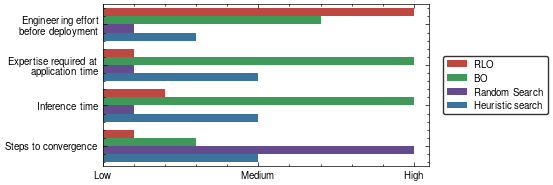

In [5]:
# Bar plot with three groups of four separate bars
points_bar = points.clip(0.1, 1.0)

plt.figure(figsize=(510 / 72.72 * 0.6, 510 / 72.72 * 0.6 * 0.5))

sns.barplot(
    x=points_bar.transpose().flatten(),
    y=["Engineering effort\nbefore deployment"] * 4
    + ["Expertise required at\napplication time"] * 4
    + ["Inference time"] * 4
    + ["Steps to convergence"] * 4,
    hue=["RLO", "BO", "Random Search", "Heuristic search"] * 4,
    palette=[
        palette_colors[0],
        palette_colors[2],
        palette_colors[5],
        palette_colors[4],
    ],
    orient="h",
)

# plt.xlabel("Qualitative effort")
# plt.ylabel("Metric")
plt.xticks([0.0, 0.5, 1.0], ["Low", "Medium", "High"])

plt.legend(
    loc="center right",
    bbox_to_anchor=(1.38, 0.5),
    frameon=True,
    edgecolor="inherit",
)

# plt.tight_layout()
plt.savefig(f"{FIG_DIR}/rl_vs_bo_design_space_bar.pdf")

plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


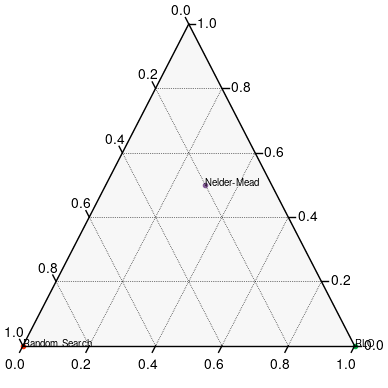

In [8]:
tick_multiple = 0.2

fig, tax = ternary.figure(scale=1.0)
fig.set_size_inches(4, 4)

tax.boundary()
tax.gridlines(multiple=tick_multiple, color="black")

tax.scatter(np.array([rlo]))
tax.annotate("RLO", rlo)
tax.scatter(np.array([bo]))
tax.annotate("BO", bo)
tax.scatter(np.array([random_search]))
tax.annotate("Random Search", random_search)
tax.scatter(np.array([nelder_mead]))
tax.annotate("Nelder-Mead", nelder_mead)

tax.ticks(
    axis="lbr", multiple=tick_multiple, linewidth=1, tick_formats="%.1f", offset=0.02
)

tax.clear_matplotlib_ticks()
tax.get_axes().axis("off")

plt.tight_layout()
plt.show()

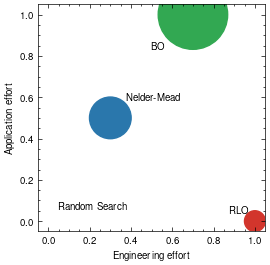

In [9]:
points_2d = points.copy()
points_2d[:, -1] = points_2d[:, -1].clip(0.1, 1.0)

plt.figure(figsize=(510 / 72.72 * 0.4, 510 / 72.72 * 0.4 * 1.0))

plt.scatter(
    points_2d[:, 0],
    points_2d[:, 1],
    s=(points_2d[:, 2] * 50) ** 2,
    c=[palette_colors[0], palette_colors[2], palette_colors[5], palette_colors[4]],
)

plt.annotate(
    "RLO", rlo[0:2], xytext=(-4, 4), textcoords="offset points", ha="right", va="bottom"
)
plt.annotate(
    "BO", bo[0:2], xytext=(-20, -20), textcoords="offset points", ha="right", va="top"
)
plt.annotate(
    "Random Search",
    random_search[0:2],
    xytext=(7, 7),
    textcoords="offset points",
    ha="left",
    va="bottom",
)
plt.annotate(
    "Nelder-Mead",
    nelder_mead[0:2],
    xytext=(11, 11),
    textcoords="offset points",
    ha="left",
    va="bottom",
)

plt.xlabel("Engineering effort")
plt.ylabel("Application effort")
# Size is runtime complexity

plt.gca().set_aspect("equal")

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/rl_vs_bo_design_space_new.pdf")

plt.show()

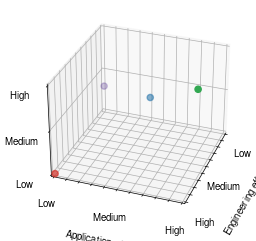

In [6]:
# 3d scatter plot
fig = plt.figure(figsize=(510 / 72.72 * 0.4, 510 / 72.72 * 0.4 * 1.0))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    points[:, 0],
    points[:, 1],
    points[:, 2],
    c=[palette_colors[0], palette_colors[2], palette_colors[5], palette_colors[4]],
)

ax.set_xlabel("Engineering effort")
ax.set_ylabel("Application effort")
ax.set_zlabel("Runtime complexity")

ax.set_xticks([0.0, 0.5, 1.0])
ax.set_yticks([0.0, 0.5, 1.0])
ax.set_zticks([0.0, 0.5, 1.0])

ax.set_xticklabels(["Low", "Medium", "High"])
ax.set_yticklabels(["Low", "Medium", "High"])
ax.set_zticklabels(["Low", "Medium", "High"])

ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.set_zlim(0.0, 1.0)

# Change the view angle
ax.view_init(30, 20)

# plt.tight_layout()
plt.savefig(f"{FIG_DIR}/rl_vs_bo_design_space_3d.pdf")

plt.show()

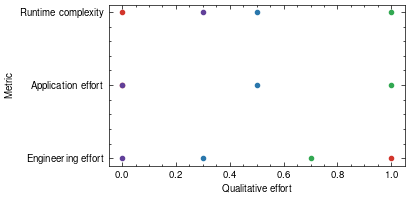

In [8]:
# 2D scatter plot with effort of the x axis and the categories on the y axis

plt.figure(figsize=(510 / 72.72 * 0.6, 510 / 72.72 * 0.6 * 0.5))

plt.scatter(
    rlo,
    ["Engineering effort", "Application effort", "Runtime complexity"],
    c=palette_colors[0],
)
plt.scatter(
    bo,
    ["Engineering effort", "Application effort", "Runtime complexity"],
    c=palette_colors[2],
)
plt.scatter(
    random_search,
    ["Engineering effort", "Application effort", "Runtime complexity"],
    c=palette_colors[5],
)
plt.scatter(
    nelder_mead,
    ["Engineering effort", "Application effort", "Runtime complexity"],
    c=palette_colors[4],
)

plt.xlabel("Qualitative effort")
plt.ylabel("Metric")

plt.tight_layout()

plt.show()

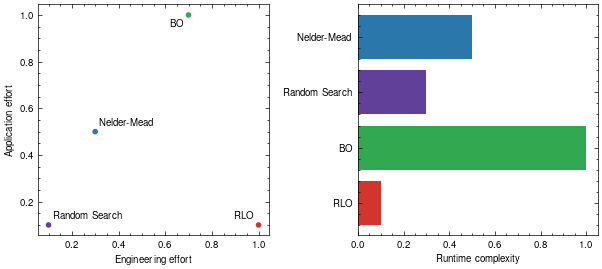

In [9]:
plt.figure(figsize=(510 / 72.72 * 0.4 * 2.2, 510 / 72.72 * 0.4 * 1.0))

plt.subplot(1, 2, 1)

plt.scatter(
    points_bar[:, 0],
    points_bar[:, 1],
    c=[palette_colors[0], palette_colors[2], palette_colors[5], palette_colors[4]],
)

plt.annotate(
    "RLO",
    (points_bar[0, 0], points_bar[0, 1]),
    xytext=(-3, 3),
    textcoords="offset points",
    ha="right",
    va="bottom",
)
plt.annotate(
    "BO",
    (points_bar[1, 0], points_bar[1, 1]),
    xytext=(-3, -3),
    textcoords="offset points",
    ha="right",
    va="top",
)
plt.annotate(
    "Random Search",
    (points_bar[2, 0], points_bar[2, 1]),
    xytext=(3, 3),
    textcoords="offset points",
    ha="left",
    va="bottom",
)
plt.annotate(
    "Nelder-Mead",
    (points_bar[3, 0], points_bar[3, 1]),
    xytext=(3, 3),
    textcoords="offset points",
    ha="left",
    va="bottom",
)

plt.xlabel("Engineering effort")
plt.ylabel("Application effort")
# Size is runtime complexity

plt.gca().set_aspect("equal")

plt.subplot(1, 2, 2)

plt.barh(
    ["RLO", "BO", "Random Search", "Nelder-Mead"],
    [points_bar[0, 2], points_bar[1, 2], points_bar[2, 2], points_bar[3, 2]],
    color=[palette_colors[0], palette_colors[2], palette_colors[5], palette_colors[4]],
)

plt.xlabel("Runtime complexity")

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/rl_vs_bo_design_space_new.pdf")

plt.show()